# FAST - Fast Accelerated Segment Test

<https://www.edwardrosten.com/work/rosten_2006_machine.pdf>

Edward Rosten, Tom Drummond (2006)

1. The contiguous circle test (9/16 or 12/16) works well to detect "corners" -- this is the segment test.
2. There is a heuristic check (compass direction pixels) to eliminate obvious False Positives. But...
  1. This makes unreasonable assumptions on the orientation of the corner (right angled).
  2. Does not generalise for anything other than 12/16
3. The paper proposes to train a ID3 Decision Tree. 
  1. Input is the 16 bit vector for every corner/non-corner detected by FAST.
  2. Target is the outcome of the segment test.
4. Now, instead of running 16 different checks per pixel, you can simply use the if-else ruleset from the Tree.

**Conclusions**
1. Works surprisingly well in practice.
2. Is extremely sensitive to the threshold -- especially for real-world data.
3. No comments in the paper on image pre-processing: low-res + gaussian smoothening is what I plan to do.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [3]:
import os, sys

In [4]:
!ls -lhtr box/frames/

total 8536
-rw-r--r--@ 1 tejaswin.p  1493847943   331K Nov  4  2008 frame_11.png
-rw-r--r--@ 1 tejaswin.p  1493847943   309K Nov  4  2008 frame_10.png
-rw-r--r--@ 1 tejaswin.p  1493847943   313K Nov  4  2008 frame_1.png
-rw-r--r--@ 1 tejaswin.p  1493847943   292K Nov  4  2008 frame_0.png
-rw-r--r--@ 1 tejaswin.p  1493847943   298K Nov  4  2008 frame_7.png
-rw-r--r--@ 1 tejaswin.p  1493847943   297K Nov  4  2008 frame_6.png
-rw-r--r--@ 1 tejaswin.p  1493847943   293K Nov  4  2008 frame_5.png
-rw-r--r--@ 1 tejaswin.p  1493847943   311K Nov  4  2008 frame_4.png
-rw-r--r--@ 1 tejaswin.p  1493847943   310K Nov  4  2008 frame_3.png
-rw-r--r--@ 1 tejaswin.p  1493847943   323K Nov  4  2008 frame_2.png
-rw-r--r--@ 1 tejaswin.p  1493847943   278K Nov  4  2008 frame_13.png
-rw-r--r--@ 1 tejaswin.p  1493847943   326K Nov  4  2008 frame_12.png
-rw-r--r--@ 1 tejaswin.p  1493847943   291K Nov  4  2008 frame_9.png
-rw-r--r--@ 1 tejaswin.p  1493847943   267K Nov  4  2008 frame_8.png


In [5]:
from skimage.transformnsform import resize

In [6]:
frame = plt.imread('box/frames/frame_0.png')
frame.min(), frame.max()

(0.0627451, 0.99215686)

In [7]:
frame = np.dot(frame[..., :3], [0.333, 0.333, 0.333])

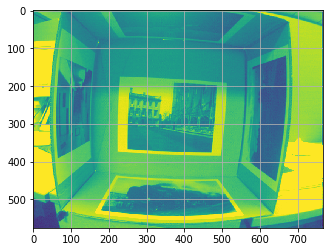

In [8]:
im = plt.imshow(frame)
ax = plt.gca()
ax.grid();

In [9]:
def load_frame(fpath):
    frame = plt.imread(fpath)
    return np.dot(frame[..., :3], [0.333, 0.334, 0.333])

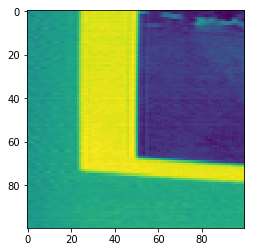

In [10]:
plt.imshow(frame[300:400, 200:300]);

NameError: name 'circle_mask' is not defined

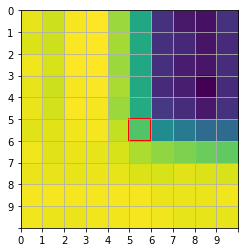

In [11]:
## Approx location -- (365, 250)
section = frame[300:400, 200:300][62:72, 45:55]

im = plt.imshow(section)
ax = plt.gca()

ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))

ax.set_yticks(np.arange(-0.5, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))

ax.grid();

center = patches.Rectangle((5-0.5,5-0.5),1,1,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(center)

v_pix = section[5, 5]
v_xs = []
for num, (ox, oy) in enumerate(circle_mask):
    p = patches.Rectangle((5+ox-0.5, 5+oy-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    v_xs.append(section[5+ox, 5+oy])
    ax.add_patch(p)
    ax.text(5+oy, 5+ox, str(num), ha='center',va='center',color='red')
    
_pixmask = circle_mask + np.array([5, 5])
print "Pixel :", v_pix
print "Circle:", v_xs
print "Indexd:", section[_pixmask[:, 0], _pixmask[:, 1]]
print np.allclose(v_xs, section[_pixmask[:, 0], _pixmask[:, 1]])

Q1. What about the edges which don't have neighbouring pixels?

Since it's only 16 pixels, I guess we can ignore those for now ...

In [12]:
def weak_test(p, compass, t):
    # Higher means brigher.
    if sum([v>=(p+t) for v in compass]) >= 3:  # At least 3 are brighter.
        return True
    elif sum([v<=(p-t) for v in compass]) >= 3:  # At least 3 are darker.
        return True
    else:
        return False

In [13]:
import pdb

In [156]:
def segment_test(p, circle, t):
    vector = []
    for x in circle:
        if x <= (p-t):
            vector.append(-1)
        elif (p-t) < x < (p+t):
            vector.append(0)
        else:
            vector.append(1)

    extended = np.tile(circle, 2)

    for i in range(circle.shape[0]):
        subset = extended[i:i+9]
        if np.alltrue(subset > (p+t)) or np.alltrue(subset < (p-t)):
            return True, vector
        
    return False, vector

In [15]:
from tqdm import tqdm_notebook
import random

In [157]:
# circle_mask = np.array([
#     [ 0, -3],
#    [ 1, -3],
#    [ 2, -2],
#    [ 3, -1],
#    [ 3,  0],
#    [ 3,  1],
#    [ 2,  2],
#    [ 1,  3],
#    [ 0,  3],
#     [-1,  3],
#    [-2,  2],
#    [-3,  1],
#    [-3,  0],
#    [-3, -1],
#    [-2, -2],
#    [-1, -3]
# ])
circle_mask = np.array([
    [-3, 0],
    [-3, 1],
    [-2, 2],
    [-1, 3],
    [0, 3],
    
    [1, 3],
    [2, 2],
    [3, 1],
    [3, 0],
    
    [3, -1],
    [2, -2],
    [1, -3],
    [0, -3],
    
    [-1, -3],
    [-2, -2],
    [-3, -1]
])

compass_mask = [0, 4, 8, 12]

def generate_corner_data(frame, threshold=0.07):
    rows, cols = frame.shape[0], frame.shape[1]
    potentials = []
    locations = []
    trainX, trainY = [], []
    for i in tqdm_notebook(range(3, rows - 3)):
        for j in range(3, cols - 3):

            pmask = circle_mask + np.array([[i, j]])
            xvals = frame[pmask[:, 0], pmask[:, 1]]
            # compvals = xvals[compass_mask]
            # if weak_test(pval, compvals, threshold):

            pval = frame[i, j]

            successful, vector = segment_test(pval, xvals, threshold)
            if successful is True:
                potentials.append([i, j])
                trainX.append(vector)
                trainY.append(1)  # This is a corner.
            else:
                if random.random() < 0.3:  # Don't take all of them... sample about 30%
                    trainX.append(vector)
                    trainY.append(0)
                    
            locations.append([i, j])
                    
    return trainX, trainY, potentials, locations

In [17]:
all_paths = [os.path.join('box/frames', name) for name in os.listdir('box/frames') if name.endswith('.png')]
train_paths = all_paths[:12]
test_paths = all_paths[12:20]

In [18]:
trainX, trainY = [], []
for fpath in train_paths:
    frame = load_frame(fpath)
    fx, fy, potentials, _ = generate_corner_data(frame, threshold=0.1)
    trainX.extend(fx)
    trainY.extend(fy)

In [19]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [20]:
print "Total:", trainY.shape[0]
print "Corners:", np.sum(trainY)

Total: 1567977
Corners: 6669


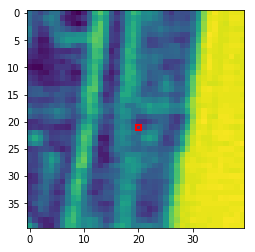

In [21]:
cx, cy = random.choice(potentials)
cpatch = frame[cx-20:cx+20, cy-20:cy+20]
crect = patches.Rectangle((20-0.5, 20+0.5), 1, 1, linewidth=2,edgecolor='r',facecolor='none')
im = plt.imshow(cpatch)
ax = plt.gca()
ax.add_patch(crect);

340 631


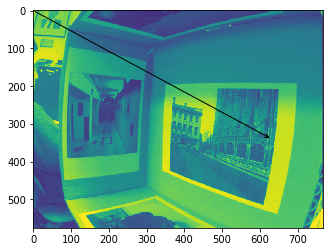

In [22]:
print cx,cy
im = plt.imshow(frame)
ax = plt.gca()
ax.annotate("", xy=(cy, cx), xytext=(0, 0), arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

# id3 code + sample data

In [23]:
ball_data, ball_target = [], []
import csv
with open('/Users/tejaswin.p/Downloads/id3_test_data - Sheet1.csv') as fp:
    reader = csv.DictReader(fp)
    ball_columns = reader.fieldnames
    for row in reader:
        ball_data.append([row[c] for c in ball_columns[1:-1]])
        ball_target.append(row[ball_columns[-1]])
        
ball_target = [True if x=='Yes' else False for x in ball_target]
ball_names = ball_columns[1:-1]

In [24]:
def calc_truth_entropy(numtrue, numtotal):
    if (numtrue == numtotal) or (numtrue == 0):
        return 0
    
    p = numtrue*1.0/numtotal
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def check_all_same(arr):
    if np.alltrue(arr) or np.alltrue(arr == False):
        return True
    else:
        return False

In [25]:
from collections import Counter
import pdb

In [26]:
def find_splits(x, y, tree, remainfeats):
    if check_all_same(y):
        # print "Found a leaf!", tree
        return y[0]
    else:        
        # Find the `current`(parent) entropy ...
        numtrue = int(np.sum(y))
        numtotal = y.shape[0]
        
        parent_entropy = calc_truth_entropy(numtrue, numtotal)
        
        # Find entropy of all remaining features to calculate InfoGain ...
        infogain = {}
        metadata = {}
        for ix in remainfeats:  # `f_ix` == feature_index
            val_count = Counter(x[:, ix])
            true_count = {k:int(np.sum(y[x[:, ix]==k] == True)) for k in val_count}
            
            metadata[ix] = val_count
            
            feature_entropy = 0
            for key in val_count:
                knum = val_count[key]
                feature_entropy += float(knum)/numtotal * calc_truth_entropy(true_count[key], knum)
                
            infogain[ix] = parent_entropy - feature_entropy
            
        # Get the highest gaining feature ...
        split = sorted(infogain.items(), key=lambda x:x[1])[-1][0]
        fvals = metadata[split]
        
        # Split the data into subsets for different values of the `split` variable ...
        for v in fvals:
            mask = x[:, split]==v
            subset_x = x[mask]
            subset_y = y[mask]
            
            key = (split, v)
            
            if check_all_same(subset_y):
                tree[key] = subset_y[0]
                # print "Found a leaf!", tree
            else:
                tree[key] = find_splits(subset_x, subset_y, {}, remainfeats-{split})
            
    return tree

In [27]:
_bdnp = np.array(ball_data)
_btnp = np.array(ball_target)

In [28]:
initfeats = set(range(_bdnp.shape[1]))
inittree = {}
find_splits(_bdnp, _btnp, inittree, initfeats)

{(0, 'Overcast'): True,
 (0, 'Rain'): {(3, 'Strong'): False, (3, 'Weak'): True},
 (0, 'Sunny'): {(2, 'High'): False, (2, 'Normal'): True}}

In [24]:
## Traverse a tree ...
def traverse(t, n):
    for k,v in t.items():
        column = ball_names[k[0]]
        if isinstance(v, dict):
            # go deeper ...
            n[(column, k[1])] = traverse(v, {})
        else:
            n[(column, k[1])] = v
            
    return n

In [25]:
isinstance(inittree, dict)

True

In [26]:
inittree

{(0, 'Overcast'): True,
 (0, 'Rain'): {(3, 'Strong'): False, (3, 'Weak'): True},
 (0, 'Sunny'): {(2, 'High'): False, (2, 'Normal'): True}}

In [27]:
traverse(inittree, {})

{('Outlook', 'Overcast'): True,
 ('Outlook', 'Rain'): {('Wind', 'Strong'): False, ('Wind', 'Weak'): True},
 ('Outlook', 'Sunny'): {('Humidity', 'High'): False,
  ('Humidity', 'Normal'): True}}

# id3 on frame ...

In [29]:
trainX.shape, trainY.shape

((1567977, 16), (1567977,))

In [30]:
fastfeats = set(range(trainX.shape[1]))

fasttree = find_splits(x=trainX, y=trainY, tree={}, remainfeats=fastfeats)
fasttree

{(8,
  -1): {(15,
   -1): {(4,
    -1): {(6,
     -1): {(2,
      -1): {(1,
       -1): {(5,
        -1): {(10,
         -1): {(3,
          -1): {(9,
           -1): {(0, -1): {(7, -1): 1, (7, 0): {(14, -1): 1, (14, 0): 0}}, (0,
            0): {(12, -1): 1, (12, 0): 0}}, (9,
           0): {(13, -1): {(14, -1): {(0, -1): 1, (0, 0): 0}, (14, 0): 0}, (13,
            0): 0}}, (3,
          0): {(12, -1): {(14, -1): {(11, -1): 1, (11, 0): 0},
           (14, 0): 0}, (12, 0): 0}}, (10,
         0): {(14,
          -1): {(7,
           -1): {(0,
            -1): {(3, -1): {(9, -1): 1, (9, 0): {(13, -1): 1, (13, 0): 0}}, (3,
             0): 0}, (0, 0): 0}, (7, 0): {(11, -1): 1, (11, 0): 0}}, (14,
          0): 0}, (10, 1): {(13, -1): 1,
         (13, 0): 0,
         (13, 1): {(14, -1): 1, (14, 1): 0}}}, (5,
        0): {(13,
         -1): {(11, -1): {(14, -1): {(0, -1): 1, (0, 0): 0}, (14, 0): 0}, (11,
          0): 0}, (13, 0): 0}}, (1,
       0): {(9,
        -1): {(12,
         -1): {(

In [158]:
test_frame = load_frame(test_paths[-1])

print test_frame.shape
# test_frame = resize(test_frame, (357, 478), anti_aliasing=True)
# print test_frame.shape

(576, 768)


In [164]:
testX, testY, test_potentials, test_locations = generate_corner_data(test_frame, threshold=0.1)

In [160]:
len(test_potentials)

2354

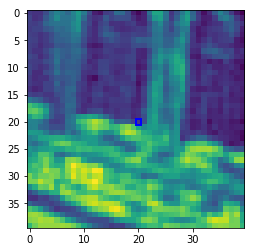

In [165]:
cx, cy = random.choice(test_potentials)
cpatch = test_frame[cx-20:cx+20, cy-20:cy+20]
crect = patches.Rectangle((20-0.5, 20-0.5), 1, 1, linewidth=2,edgecolor='blue',facecolor='none')
im = plt.imshow(cpatch)
ax = plt.gca()
ax.add_patch(crect);

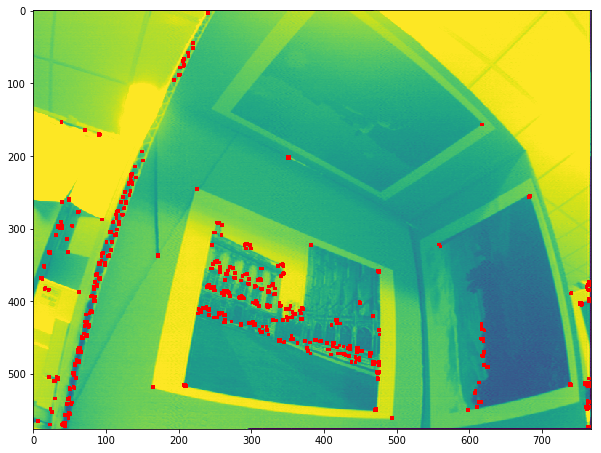

In [166]:
plt.figure(figsize=(10, 10))
plt.imshow(test_frame)
ax = plt.gca()
for _x, _y in tqdm_notebook(test_potentials):
    _rect = patches.Rectangle((_y-0.5, _x-0.5), 2, 2, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(_rect)

In [105]:
test_paths[-1]

'box/frames/frame_8.png'

In [147]:
import cv2
fastCV2 = cv2.FastFeatureDetector_create()

In [155]:
fastCV2.getType?

In [148]:
fastCV2.setThreshold(25)

In [167]:
img = cv2.imread('/Users/tejaswin.p/Downloads/IMG_20200414_195432.jpg', 0)
# img = cv2.imread('/Users/tejaswin.p/THIS_LAPTOP_projects/c00lHaX/fast_corner/box/frames/frame_8.png')

In [168]:
kp = fastCV2.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

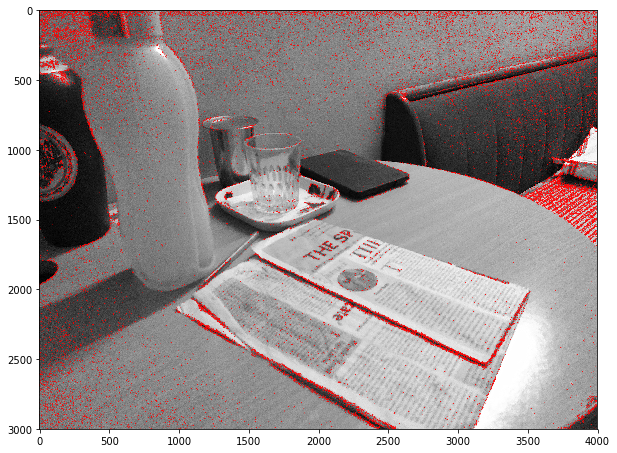

In [169]:
plt.figure(figsize=(10, 10))
plt.imshow(img2)

In [44]:
def navigate_fast(vector, tree):
    parents = tree.keys()
    feature = parents[0][0]
    value = vector[feature]
    
    decision = tree[(feature, value)]
    if isinstance(decision, int):
        return decision
    else:
        return navigate_fast(vector, decision)
    
    return decision

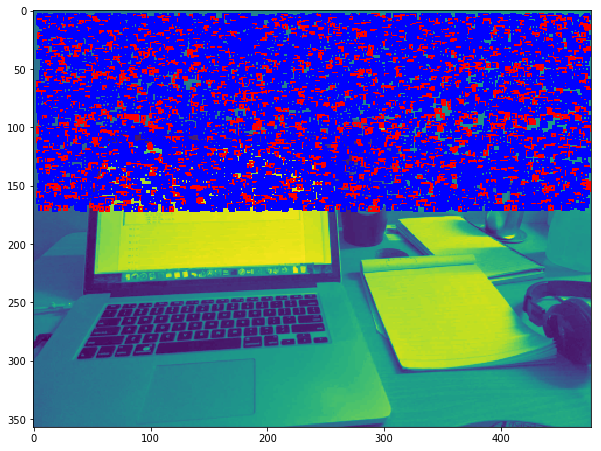

In [45]:
plt.figure(figsize=(10, 10))
plt.imshow(test_frame)
ax = plt.gca()

for ix, tvec in enumerate(testX):
    _x, _y = test_locations[ix]
    circle = testY[ix]
    try:
        fastID3 = navigate_fast(tvec, fasttree)
    
        if circle == 1 and fastID3 == 0:
            _rect = patches.Rectangle((_y-0.5, _x-0.5), 3, 3, linewidth=2,edgecolor='red',facecolor='none')
            ax.add_patch(_rect)
#         elif circle == 0 and fastID3 == 1:
#             _rect = patches.Rectangle((_y-0.5, _x-0.5), 3, 3, linewidth=2,edgecolor='orange',facecolor='none')
#             ax.add_patch(_rect)
        else:
            pass
        
    except KeyError:
        _rect = patches.Rectangle((_y-0.5, _x-0.5), 3, 3, linewidth=2,edgecolor='blue',facecolor='none')
        ax.add_patch(_rect)

In [31]:
from collections import defaultdict

In [32]:
def count_levels(t, l, c):  # Tree, LevelTracker, CurrentLevel
    for k,v in t.items():
        print c, l
        
        l[c] += 1  # All keys are at the current level.
    
        if isinstance(v, dict):
            l = count_levels(v, l, c+1)
        else:
            l[c+1] += 1  # The values will be at the next level.
            
    return l

In [33]:
count_levels(inittree, defaultdict(int), 0)

0 defaultdict(<type 'int'>, {})
1 defaultdict(<type 'int'>, {0: 1})
1 defaultdict(<type 'int'>, {0: 1, 1: 1, 2: 1})
0 defaultdict(<type 'int'>, {0: 1, 1: 2, 2: 2})
0 defaultdict(<type 'int'>, {0: 2, 1: 3, 2: 2})
1 defaultdict(<type 'int'>, {0: 3, 1: 3, 2: 2})
1 defaultdict(<type 'int'>, {0: 3, 1: 4, 2: 3})


defaultdict(int, {0: 3, 1: 5, 2: 4})

# Next, calculate the width at each level ...

In [74]:
class Node:
    def __init__(self, identity, leaf, row=0, col=0):
        self.identity = identity
        self.leaf = leaf
        self.row = row
        self.col = col
        
    def __repr__(self):
        return str(self.identity) + '_' + str((self.row, self.col))
    def __str__(self):
        return str(self.identity) + '_' + str((self.row, self.col))
        
def make_nodes(t, n, r):  # r == current depth.
    for k,v in t.items():
        node_k = Node(k, False, row=r)
        if type(v) == bool:
            n[node_k] = Node(v, True, row=r+1)
            
        else:  # It is a dict
            n[node_k] = make_nodes(v, {}, r+1)
                
    return n

In [84]:
test = {
    'f1 -1': {'f2 -1': True, 'f2 0': False, 'f2 1': False},
    'f1 0': True,
    'f1 1': {'f3 -1': False, 'f3 0': False, 'f3 1': True}
}
mwdepth = make_nodes(test, {}, 0)
mwdepth

{f1 1_(0, 0): {f3 -1_(1, 0): False_(2, 0),
  f3 1_(1, 0): True_(2, 0),
  f3 0_(1, 0): False_(2, 0)},
 f1 -1_(0, 0): {f2 1_(1, 0): False_(2, 0),
  f2 0_(1, 0): False_(2, 0),
  f2 -1_(1, 0): True_(2, 0)},
 f1 0_(0, 0): True_(1, 0)}

In [97]:
def track_columns(t, pc):  # Tree, ParentColumn
    keys = t.keys()  # Parent level.
    for k in keys:
        if k.identity[-2:] == '-1':
            left = k
        elif k.identity[-1] == '0':
            middle = k
        else:
            right = k
            
    track_columns()

In [98]:
track_columns(mwdepth, 0)

f1 -1_(0, 0) f1 0_(0, 0) f1 1_(0, 0)


In [20]:
def pascal_incremental(k):
    central = []
    
    for i in range(k):
        if i == 0:
            central.append(0)
        elif i == 1:
            

In [ ]:
range()

In [21]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
solve_inplace(range(10), 3)

[7, 8, 9, 0, 1, 2, 3, 4, 5, 6]

In [11]:
generate_positions(0, 10, )

[7, 4, 1, 8, 5, 2, 9, 6, 3, 0]

In [10]:
generate_positions(1, 10, 3)

[4, 7, 0, 3, 6, 9, 2, 5, 8, 1]